In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from keras.regularizers import l1

def build():
    network = keras.models.Sequential()
    network.add(Dense(x_train.shape[1], activation='elu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-4)))
    network.add(Dense(24, activation='relu', kernel_regularizer=l2(1.e-4)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return network

#Data preparation for regression NFL
def data_prep(data):
    data = pd.get_dummies(data)
    y = data['FirstDown']
    x = data.drop(columns = ['FirstDown'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['YardLine', 'Distance', 'DefendersInTheBox']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
        
    return x_train, x_test, y_train, y_test

#Regression k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Mean Absolute Error of the network is ', mae)
    with open('historyPredNFL.txt', 'w') as outfile:
        for x in range(len(val_history)):
            print(x, ' ', val_history[x], ' ', train_history[x], file=outfile)
    
    return model

In [64]:
data = pd.read_csv("NFLwFormation.csv")
data['FirstDown'] = 20
data['FirstDown'] = data['FirstDown'].where(data['Distance'] <= data['Yards'], 0)
data['FirstDown'] = data['FirstDown'].mask(data['Distance'] <= data['Yards'], 1)

data = data.drop(columns = ['Yards'])
data

,YardLine,Quarter,Down,Distance,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,FirstDown
0,65,1,3,2,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",1
1,57,1,1,10,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",0
2,35,1,1,10,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",0
3,2,1,2,2,JUMBO,"6 OL, 2 RB, 2 TE, 0 WR",9.0,"4 DL, 4 LB, 3 DB",1
4,75,1,1,10,SHOTGUN,"1 RB, 3 TE, 1 WR",7.0,"3 DL, 2 LB, 6 DB",0
...,...,...,...,...,...,...,...,...,...
30998,54,4,1,10,PISTOL,"2 RB, 2 TE, 1 WR",8.0,"4 DL, 3 LB, 4 DB",0
30999,53,4,2,9,PISTOL,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",0
31000,13,4,1,10,SINGLEBACK,"1 RB, 1 TE, 3 WR",8.0,"3 DL, 3 LB, 5 DB",0
31001,63,4,1,10,PISTOL,"2 RB, 1 TE, 2 WR",7.0,"4 DL, 3 LB, 4 DB",0


In [65]:
x_train, x_test, y_train, y_test = data_prep(data)

Input size:  (24802, 117)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 117)               13806     
_________________________________________________________________
dense_43 (Dense)             (None, 24)                2832      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 25        
Total params: 16,663
Trainable params: 16,663
Non-trainable params: 0
_________________________________________________________________
None


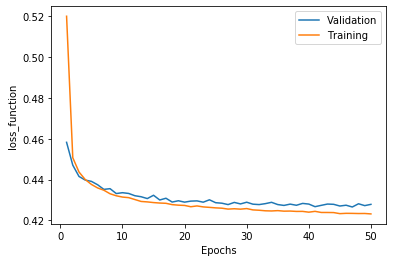

194/194 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8300
Mean Absolute Error of the network is  0.8300274014472961


In [66]:
model = cross_valid_reg(3, 50, x_train, y_train, x_test, y_test)

In [86]:
probs = []
for x in model.predict_proba(x_test).tolist():
    probs.append(x[0])

FD = y_test.tolist()